In [ ]:
!pip install SciencePlots # !pip install git+https://github.com/garrettj403/SciencePlots

# Control con un PID

In [ ]:
import scienceplots
# plt.style.available #tienen que aparecer science y ieee

## Definición del modelo del motor

In [ ]:
def modmotor(t_etapa, xant, accion):
    """
    Simula el modelo de un motor eléctrico para identificación.
    Parámetros:
    - t_etapa: duración de la etapa de simulación (segundos)
    - xant: estado anterior [ia, wr, tita_r]
    - accion: entrada [Va, TL]

    Retorna:
    - X: nuevo estado [ia, wr, tita_r]
    """
# Constantes Iniciales
    Ra=2.27;Laa=0.0047;Ki=0.25;Kb=0.25;Bm=0.00131;Jm=0.00233; #%Motor

# Constantes Identificadas (son para calcular el controlador, Observador y PID)
    # Ra= 2.2781228953606902 ; Laa= 0.005187184919244553 ; Ki= 0.2618711775870197
    # Jm= 0.002848787974411428 ; Bm= 0.0014279727330389095 ; Kb= 0.2499435593696499

    h = 0.0004247701268049  # Paso de integración
    # Variables de estado
    ia, wr, titar = xant
    Va, TL = accion
    # Número de pasos de integración
    pasos = int(t_etapa / h)
    for _ in range(pasos):
        ia_p = -(Ra / Laa) * ia - (Kb / Laa) * wr + (1 / Laa) * Va
        wr_p = (Ki / Jm) * ia - (Bm / Jm) * wr - (1 / Jm) * TL
        ia += ia_p * h
        wr += wr_p * h
        titar += wr * h
    return np.array([ia, wr, titar])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import place_poles

# Parámetros del sistema identificados
Ra = 2.258930051299405
Laa = 0.005026901184834716
Ki_ = 0.25965987053759737
Jm = 0.0028472626983113334
Bm = 0.0014165170369840668
Km = 0.2500481104997174

# Definición de matrices del sistema
Mat_A = np.array([
    [-Ra/Laa, -Km/Laa, 0],
    [Ki_/Jm, -Bm/Jm, 0],
    [0, 1, 0]
])
Mat_B = np.array([[1/Laa], [0], [0]])
Mat_B_T = np.array([[0], [-1/Jm], [0]])
Mat_C = np.array([0, 0, 1])

df_Motor = pd.read_excel('Curvas_Medidas_Motor_2025_v.xlsx', header=(0)) # carga desde Colab
# https://mega.nz/file/bgpXEBZI#cuYbd_6JKybi3-jN62BfpLY970EzRxkhaFOBuFuwrT0
# df_Motor = pd.read_excel('Curvas_Medidas_Motor_2025_v.xlsx', header=(0)) # carga desde Colab
# Cargar datos del archivo Excel
file_path = 'Curvas_Medidas_Motor_2025_v.xlsx'
tabla = pd.read_excel(file_path).values

t_D = tabla[:, 0]
w_D = tabla[:, 1]
ia_D = tabla[:, 2]
Va_D = tabla[:, 3]
TL_D = tabla[:, 4]

TL_Max = np.max(TL_D)

# Configuración de simulación
tF = 10  # Tiempo final
t_etapa = t_D[1] - t_D[0]  # Paso de tiempo
N = int(np.round(tF / t_etapa))

# Inicialización de variables
e = np.zeros(N + 2)
acc = np.zeros(N)
x1 = np.zeros(N)
x2 = np.zeros(N)
x3 = np.zeros(N)
TL_D1 = np.zeros(N)
titaRef_ = np.zeros(N)

# Constantes del PID
Kp = 10.0
Ki = 10.0
Kd = 0.1
color_ = 'r'
# Coeficientes del controlador PID discreto
A1 = ((2 * Kp * t_etapa) + (Ki * t_etapa**2) + (2 * Kd)) / (2 * t_etapa)
B1 = (-2 * Kp * t_etapa + Ki * t_etapa**2 - 4 * Kd) / (2 * t_etapa)
C1 = Kd / t_etapa
# Variables iniciales
X = np.array([0.0, 0.0, 0.0]).reshape(3, 1)
u = 0.0
k = 2
TL_ap = 0.0
titaRef = np.pi / 2

# Simulación principal con PID
for jj in range(N):
    tiempo_actual = jj * t_etapa
    if tiempo_actual > 0.7:
        TL_ap = TL_Max
    if tiempo_actual <= 5:
        titaRef = np.pi / 2
    else:
        titaRef = -np.pi / 2
        TL_ap = TL_Max

    X = modmotor(t_etapa, X, np.array([u, TL_ap]))
    e[k] = titaRef - X[2, 0]  # Error angular
    u += A1 * e[k] + B1 * e[k-1] + C1 * e[k-2]
    x1[jj] = X[0, 0]
    x2[jj] = X[1, 0]
    x3[jj] = X[2, 0]
    acc[jj] = u
    TL_D1[jj] = TL_ap
    titaRef_[jj] = titaRef
    k += 1
# Vector de tiempo
t = np.linspace(0, tF, N)

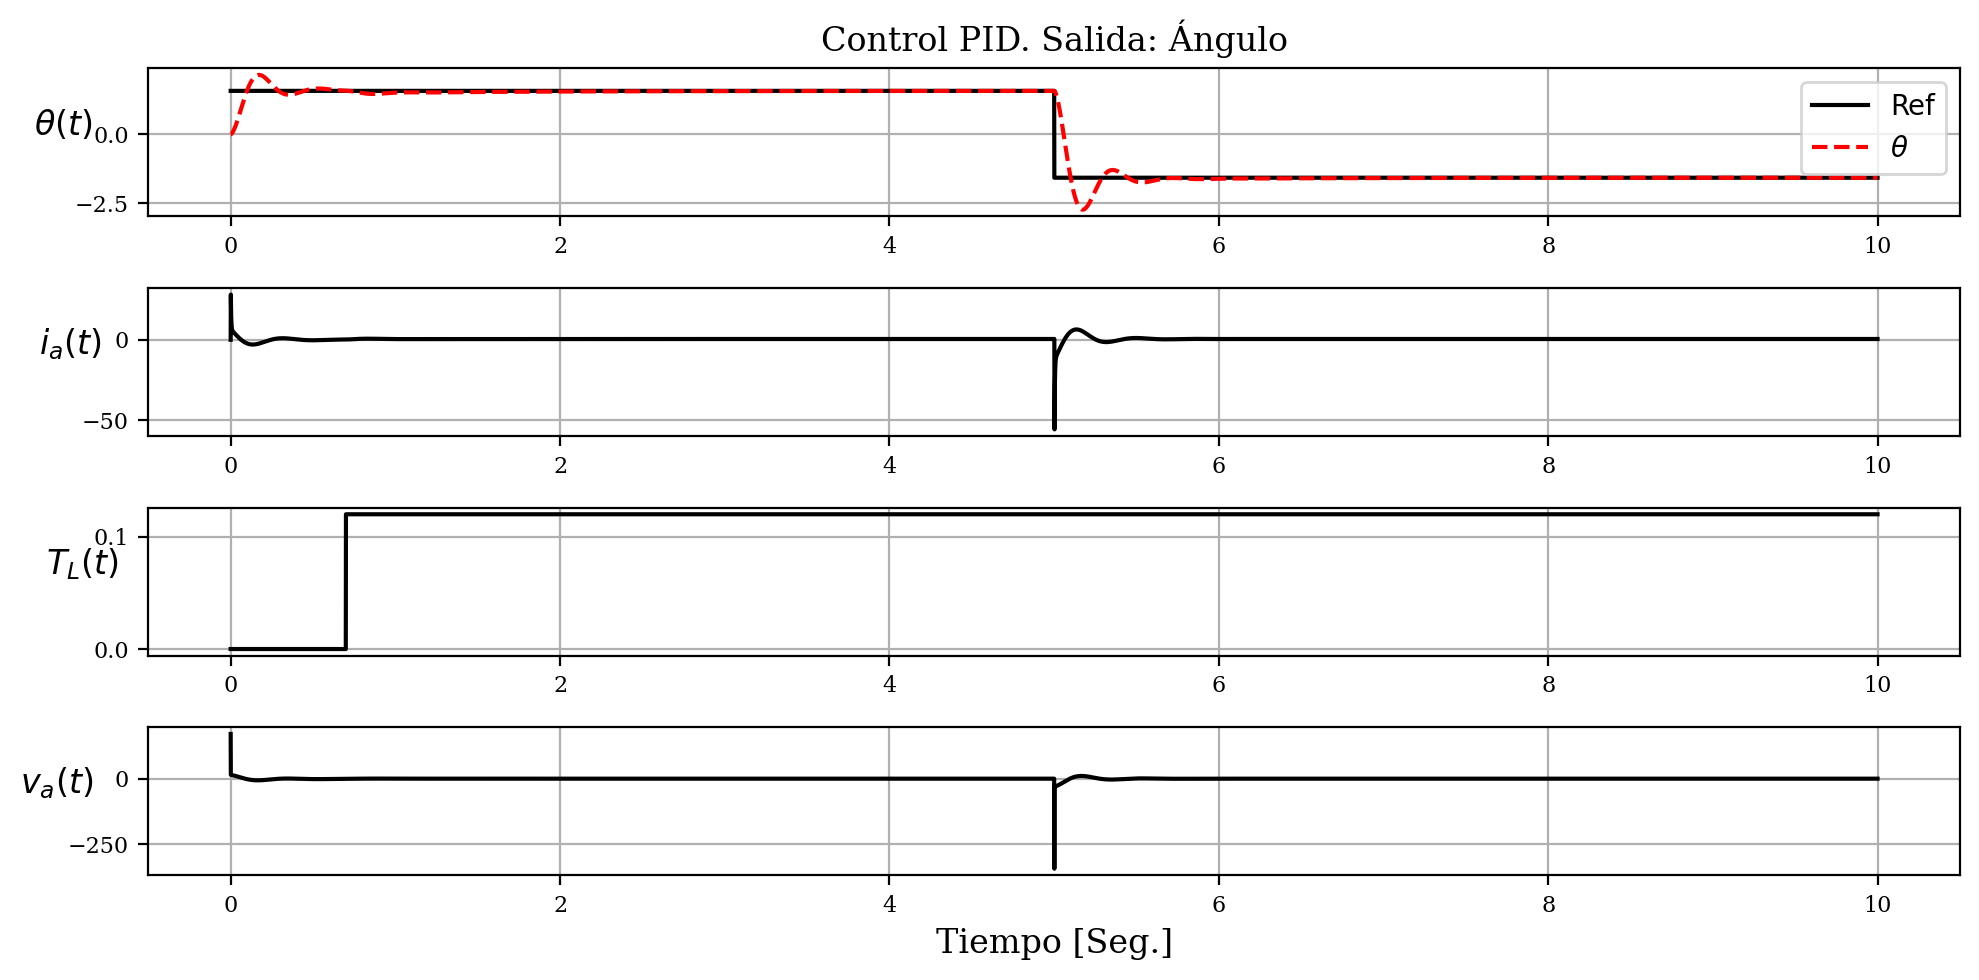

In [ ]:
with plt.style.context('ieee'): #
# with plt.style.context('dark_background'):
# with plt.style.context('seaborn-v0_8-pastel'):
# with plt.style.context('seaborn-v0_8-poster'):
  fig10, ax13 = plt.subplots(4,1,figsize=(10,5), dpi= 200)
ax13[0].set_title('Control PID. Salida: Ángulo')
ax13[0].plot(t,titaRef_, label='Ref')
ax13[0].plot(t,x3, label=r'$\theta$')
ax13[0].set_ylabel(r'$\theta{(t)}$',rotation=0, fontsize=12)

ax13[0].legend()
# ax13[0].set_ylabel(r'$\omega_r{(t)}$',rotation=0, fontsize=12)
ax13[0].grid( True )
# ax13[1].plot(df_Motor['t'],df_Motor['i_t'], label='Datos')
ax13[1].plot(t,x1, label='Corriente i_t')
# ax13[1].legend()
ax13[1].set_ylabel(r'$i_a{(t)}$',rotation=0, fontsize=12)
ax13[1].grid( True )
ax13[2].plot(t, TL_D1, label=r'Torque T_L')
ax13[2].set_ylabel(r'$T_L{(t)}$',rotation=0, fontsize=12)
ax13[2].grid( True )
ax13[3].plot(t, acc, label=r'v_a')
ax13[3].set_ylabel(r'$v_a{(t)}$',rotation=0, fontsize=12)
ax13[3].grid( True )
ax13[3].set_xlabel(r'Tiempo [Seg.]',rotation=0, fontsize=12)
plt.tight_layout()
# plt.show()

# Control en Variables de estado con Observación Luemberger

In [ ]:
#Control por espacio de estados (lugar geométrico de raíces)
print("\nTiempo de muestreo:")
print(t_etapa)
print("\nPolos menores a :", 1/(3*t_etapa),'\n\n')
# print(t_etapa)
Aa = np.vstack((
    np.hstack((Mat_A, np.zeros((3, 1)))),
    # Convert the scalar 0 to a 1x1 array for hstack
    np.hstack((-Mat_C.reshape(1, 3), np.zeros((1, 1))))
))
Ba = np.vstack((Mat_B, np.zeros((1, 1)))) # Also need to stack a 1x1 zero array with Ba

# Polos deseados
polos_deseados = np.array([-300, -50, -15, -10])

# Asignación de polos usando place
place_result = place_poles(Aa, Ba, polos_deseados)
Ka = place_result.gain_matrix
print('\nPolos del sistema en lazo cerrado:', np.linalg.eig(Aa - Ba @ Ka)[0])

# Observador (Opcional)
Ad = Mat_A.T
Bd = Mat_C.reshape(-1, 1)
Cd = Mat_B.T

# Polos observador
polos_obs = np.array([-330, -200, -220])
place_obs = place_poles(Ad, Bd, polos_obs)
Ko = place_obs.gain_matrix.T
print('\nPolos del observador:', np.linalg.eig(Mat_A - Ko @ Mat_C.reshape(1, -1))[0])


Tiempo de muestreo:
0.001

Polos menores a : 333.3333333333333 



Polos del sistema en lazo cerrado: [-300.  -50.  -15.  -10.]

Polos del observador: [-330. -220. -200.]


In [ ]:
# Simulación del comportamiento dinámico
tF = 10  # Tiempo final de simulación (ajustar según necesidad)
t_etapa = 0.001  # Paso de tiempo
N = int(tF / t_etapa)

# Condiciones iniciales
X = np.zeros((3, 1))
psi = 0
x_hat = np.zeros((3, 1))
TL_Max =.12  # Valor máximo del torque (ajustar según necesidad)

# Vectores para almacenar resultados
e = np.zeros(N)
x1 = np.zeros(N)
x2 = np.zeros(N)
x3 = np.zeros(N)
acc = np.zeros(N)
TL_D1 = np.zeros(N)
titaRef_ = np.zeros(N)

for jj in range(N):
    if jj * t_etapa > 0.7:  # Aplicar torque después de 0.7 segundos
        TL_ap = TL_Max
    else:
        TL_ap = 0

    if jj * t_etapa <= 5:  # Referencia de posición en los primeros 5 segundos
        titaRef = np.pi/2
    else:
        titaRef = -np.pi/2
        TL_ap = TL_Max

    # Simulación del sistema (simplificada - reemplazar con modelo real)
    Y = (Mat_C @ X)[0]

    # Aquí debería ir la actualización del estado X usando el modelo del motor
    # X = modmotor_inicial(t_etapa, X, [u, TL_ap])
    # Por simplicidad, usamos una aproximación lineal
    # X_dot = Mat_A @ X + Mat_B * acc[max(0, jj-1)] + Mat_B_T * TL_ap
    # X = X + X_dot * t_etapa
    e[jj] = titaRef - Y
    acc[jj] = -(Ka @ np.vstack([x_hat, psi]).flatten())[0]
    X = modmotor(t_etapa, X, np.array([acc[jj] , TL_ap]))
    # Actualización del observador
    x_hat_dot = Mat_A @ x_hat + Mat_B * acc[jj] + Ko * (Y - Mat_C @ x_hat)
    x_hat = x_hat + x_hat_dot * t_etapa

    psi = psi + e[jj] * t_etapa

    # Almacenar resultados
    x1[jj] = X[0][0]
    x2[jj] = X[1][0]
    x3[jj] = X[2][0]
    TL_D1[jj] = TL_ap
    titaRef_[jj] = titaRef

# Graficación de resultados
t = np.arange(0, tF, t_etapa)

In [ ]:
df_Motor.columns = ['t', 'wr', 'i_t', 'Vin', 'TL'] #Renombro las columnas
df_Motor.tail(3)

,t,wr,i_t,Vin,TL
1497,1.498,7.618140,0.042110,2,0.0
1498,1.499,7.618339,0.042088,2,0.0
1499,1.500,7.618536,0.042065,2,0.0


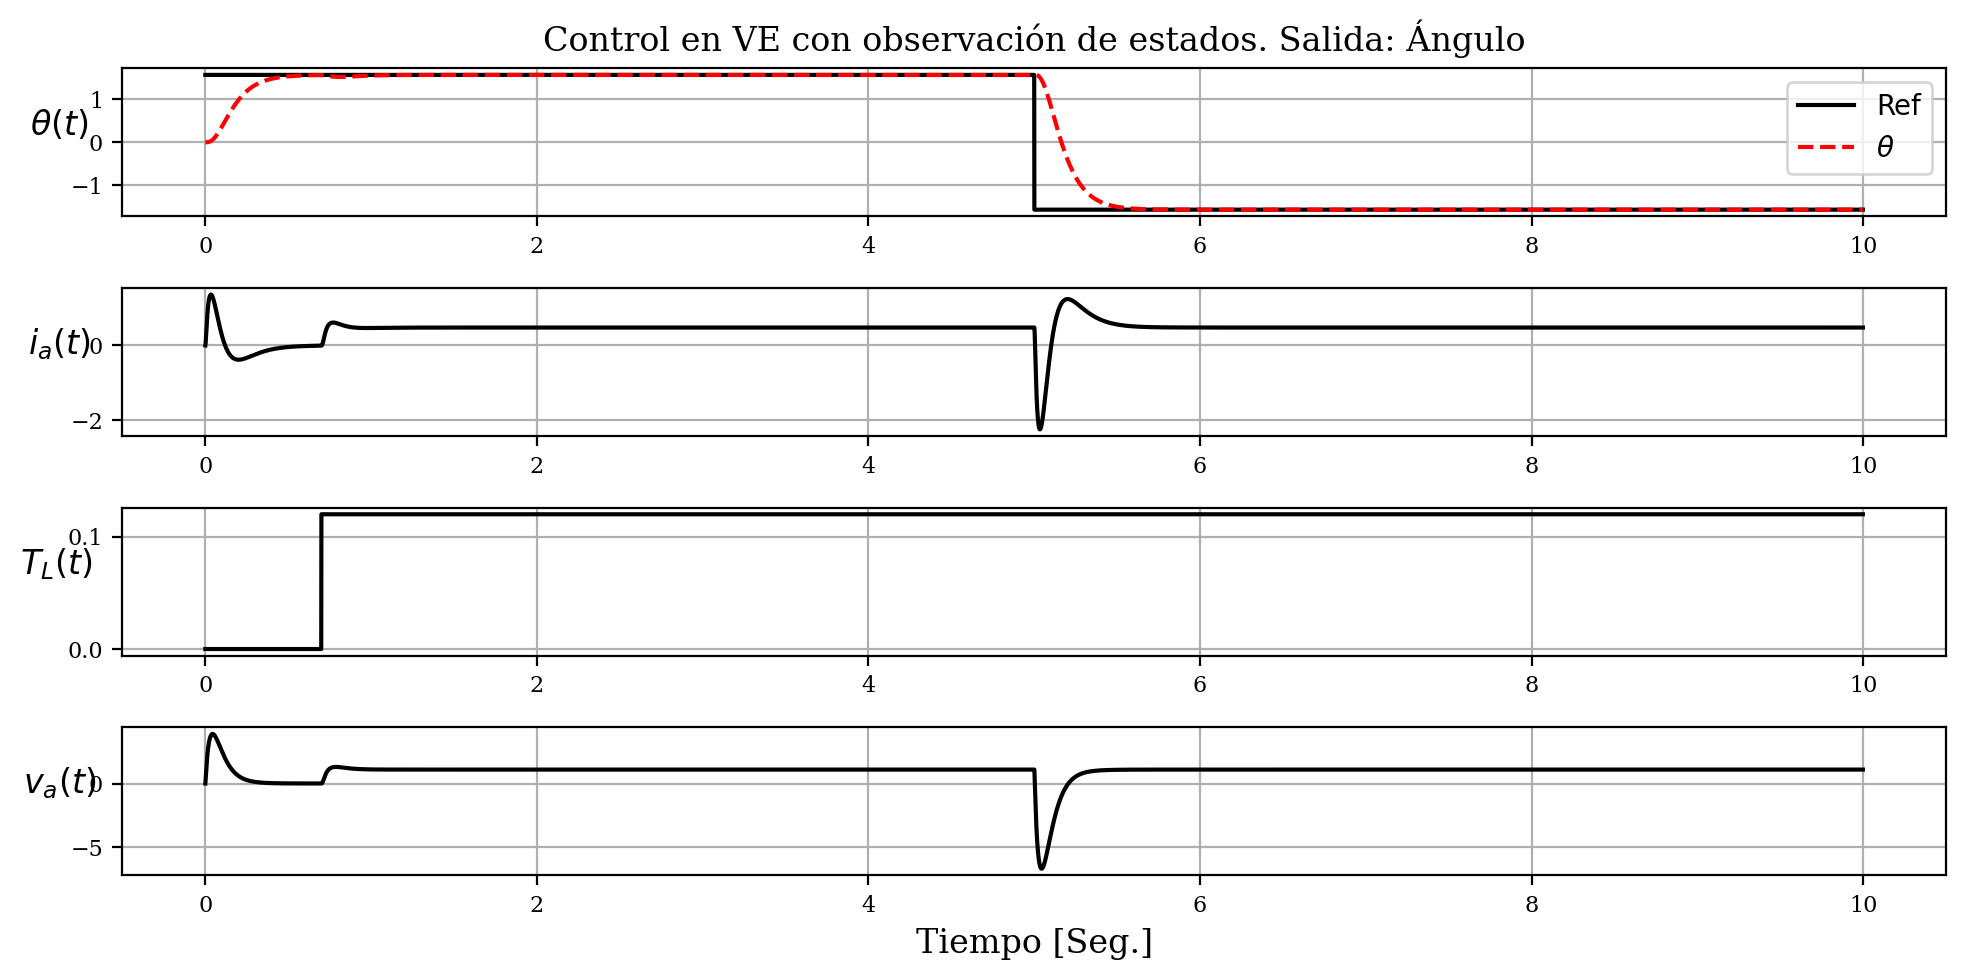

In [ ]:
with plt.style.context('ieee'): #
# with plt.style.context('dark_background'):
# with plt.style.context('seaborn-v0_8-pastel'):
# with plt.style.context('seaborn-v0_8-poster'):
  fig10, ax13 = plt.subplots(4,1,figsize=(10,5), dpi= 200)
ax13[0].set_title('Control en VE con observación de estados. Salida: Ángulo')
ax13[0].plot(t,titaRef_, label='Ref')
ax13[0].plot(t,x3, label=r'$\theta$')
ax13[0].set_ylabel(r'$\theta{(t)}$',rotation=0, fontsize=12)

ax13[0].legend()
# ax13[0].set_ylabel(r'$\omega_r{(t)}$',rotation=0, fontsize=12)
ax13[0].grid( True )
# ax13[1].plot(df_Motor['t'],df_Motor['i_t'], label='Datos')
ax13[1].plot(t,x1, label='Corriente i_t')
# ax13[1].legend()
ax13[1].set_ylabel(r'$i_a{(t)}$',rotation=0, fontsize=12)
ax13[1].grid( True )
ax13[2].plot(t, TL_D1, label=r'Torque T_L')
ax13[2].set_ylabel(r'$T_L{(t)}$',rotation=0, fontsize=12)
ax13[2].grid( True )
ax13[3].plot(t, acc, label=r'v_a')
ax13[3].set_ylabel(r'$v_a{(t)}$',rotation=0, fontsize=12)
ax13[3].grid( True )
ax13[3].set_xlabel(r'Tiempo [Seg.]',rotation=0, fontsize=12)
plt.tight_layout()
# plt.show()

# Conclusiones

El control con observación de estados por asignación de polos es más rápido de diseñar que el PID.
Debe considerarse el tiempo de muestreo para la asignación de los polos de la dinámica de lazo cerrado, del observador con el controlador.

# Cierre

Convertir de notebook ipynb a pdf desde el entorno.

In [ ]:
!pip install nbconvert
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
# !jupyter nbconvert --to pdf /content/Untitled1.ipynb

In [ ]:
!jupyter nbconvert --to pdf /content/TP_N2_PID_CyO.ipynb

In [ ]:
!jupyter nbconvert --to html /content/TP_N2_PID_CyO.ipynb